
## Pedagogical Block Bootstrap Simulation
This cell demonstrates, step by step, how a block-bootstrap Monte Carlo simulation works for a simple ETF portfolio.
We will generate synthetic returns, sample blocks, string them together, and simulate withdrawals.

First, we start with a historical returns dataset.



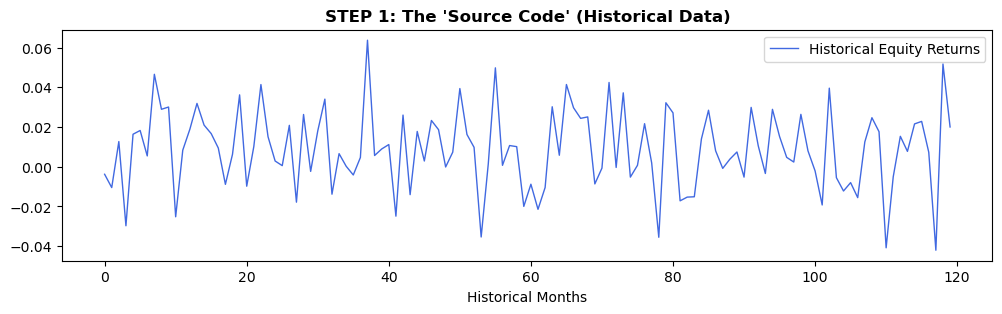

Then we randomly select chunks of returns data with a chosen average block size.



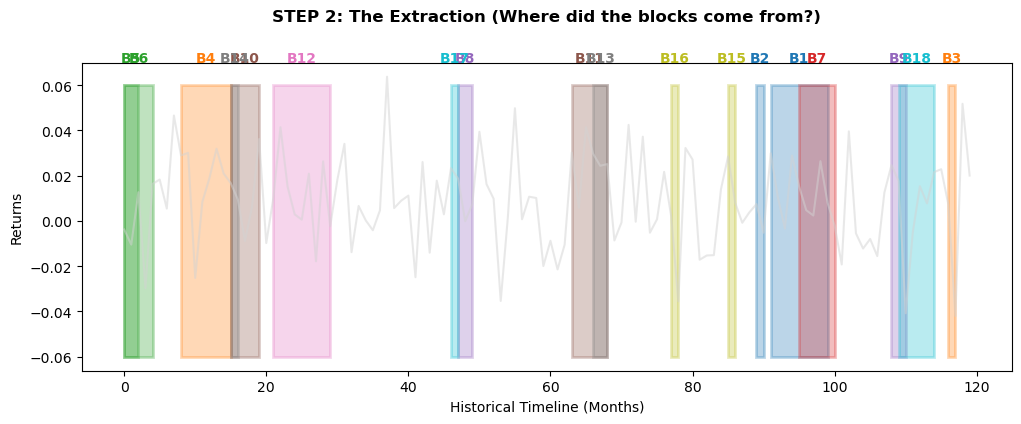

Then, we string these chunks together into a hypothetical price evolution path.



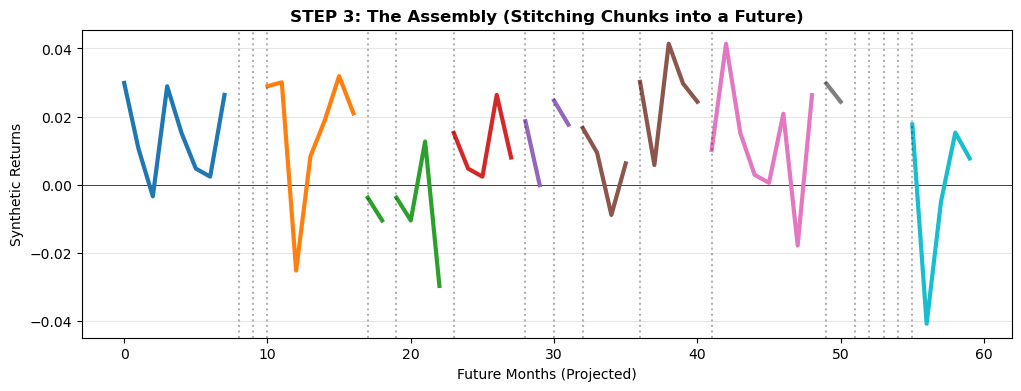

We generate several simulated histories with block-bootstrap to find the median and 5th to 95th percentile range.



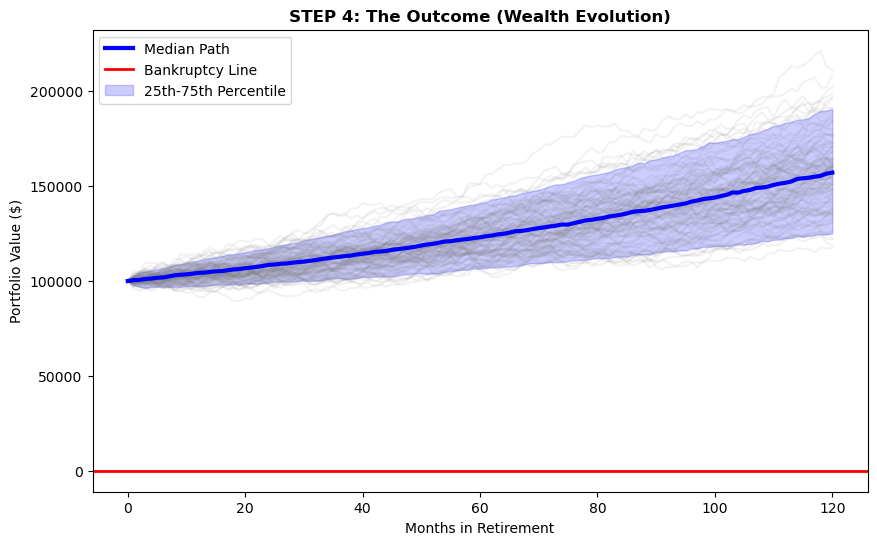

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Setup for professional visual output
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titleweight'] = 'bold'

# =================================================================
# 1. THE SOURCE: 10 Years of "Real" Market History
# =================================================================
# We create a history where assets move together (correlation)
print("First, we start with a historical returns dataset.\n")
np.random.seed(42)
history_len = 120 
mean_ret = [0.007, 0.002] # Equity vs Bonds
cov_mat = [[0.0005, 0.0001], [0.0001, 0.0001]]
history = np.random.multivariate_normal(mean_ret, cov_mat, size=history_len)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(history[:, 0], color='royalblue', lw=1, label="Historical Equity Returns")
ax.set_title("STEP 1: The 'Source Code' (Historical Data)")
ax.set_xlabel("Historical Months")
ax.legend()
plt.show()

# %% [markdown]
# ### STEP 2: The Extraction (Sampling Blocks)
# Instead of picking single dots, we pick **sequences**. 
# This preserves the "vibe" of the market (e.g., if month 5 was bad, month 6 was likely also volatile).

# %%
def pedagogical_bootstrap(data, avg_size, target_len):
    path, meta = [], []
    curr = 0
    while curr < target_len:
        start = np.random.randint(0, len(data))
        # Geometric length makes the 'rhythm' of the blocks unpredictable/natural
        length = min(np.random.geometric(1/avg_size), len(data)-start, target_len-curr)
        path.append(data[start : start + length])
        meta.append((start, length, curr))
        curr += length
    return np.vstack(path), meta

target_future = 60
synth_ret, blocks = pedagogical_bootstrap(history, 6, target_future)

# --- VISUALIZING THE EXTRACTION ---
print("Then we randomly select chunks of returns data with a chosen average block size.\n")
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(history[:, 0], color='lightgrey', alpha=0.5)
colors = plt.cm.tab10(np.linspace(0, 1, len(blocks)))

for i, (start, length, _) in enumerate(blocks):
    # Draw a box over the history where the block was 'stolen' from
    rect = patches.Rectangle((start, -0.06), length, 0.12, linewidth=2, 
                             edgecolor=colors[i], facecolor=colors[i], alpha=0.3)
    ax.add_patch(rect)
    ax.text(start + length/2, 0.07, f"B{i+1}", ha='center', color=colors[i], fontweight='bold')
ax.set_title("STEP 2: The Extraction (Where did the blocks come from?)", pad=30)
ax.set_ylabel("Returns")
ax.set_xlabel("Historical Timeline (Months)")
plt.show()

# %% [markdown]
# ### STEP 3: The Assembly (The 'Frankenstein' Path)
# We take those highlighted chunks from above and string them together chronologically 
# to build one possible "Synthetic Future."
print("Then, we string these chunks together into a hypothetical price evolution path.\n")
fig, ax = plt.subplots(figsize=(12, 4))
ax.axhline(0, color='black', lw=0.5)

for i, (start, length, path_pos) in enumerate(blocks):
    chunk = synth_ret[path_pos : path_pos + length, 0]
    ax.plot(range(path_pos, path_pos + length), chunk, color=colors[i], lw=3)
    # Visual connector (the stitch)
    if i > 0:
        ax.axvline(path_pos, color='black', linestyle=':', alpha=0.3)

ax.set_title("STEP 3: The Assembly (Stitching Chunks into a Future)")
ax.set_xlabel("Future Months (Projected)")
ax.set_ylabel("Synthetic Returns")
plt.grid(axis='y', alpha=0.3)
plt.show()

# %% [markdown]
# ### STEP 4: The Outcome (Compounding Wealth)
# Finally, we run this 1,000 times. We apply a **4% withdrawal rule**. 
# Notice how the "Sequence of Returns" (which blocks happen first) determines survival.

print("We generate several simulated histories with block-bootstrap to find the median and 5th to 95th percentile range.\n")
n_sims = 1000
future_months = 120
init_cash = 100_000
withdraw_rate = 0.04 / 12 # Monthly 4% rule
wealth_matrix = np.zeros((n_sims, future_months + 1))
wealth_matrix[:, 0] = init_cash

for s in range(n_sims):
    sim_r, _ = pedagogical_bootstrap(history, 6, future_months)
    w = init_cash
    for t in range(future_months):
        # 60/40 Portfolio return
        ret = (sim_r[t, 0] * 0.6) + (sim_r[t, 1] * 0.4)
        w = (w * (1 + ret)) - (init_cash * withdraw_rate)
        wealth_matrix[s, t+1] = max(w, 0)

# --- FINAL PLOT ---
plt.figure(figsize=(10, 6))
median_path = np.median(wealth_matrix, axis=0)
plt.plot(wealth_matrix[:100].T, color='grey', alpha=0.1) # Plot first 100 for clarity
plt.plot(median_path, color='blue', lw=3, label="Median Path")
plt.axhline(0, color='red', lw=2, label="Bankruptcy Line")
plt.fill_between(range(future_months+1), 
                 np.percentile(wealth_matrix, 5, axis=0), 
                 np.percentile(wealth_matrix, 95, axis=0), 
                 color='blue', alpha=0.2, label="25th-75th Percentile")

plt.title("STEP 4: The Outcome (Wealth Evolution)")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Months in Retirement")
plt.legend()
plt.show()

/tmp/ipykernel_24324/352176890.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2000-01-01", progress=False)['Close']


Median final wealth: $ 9,267,268
16th percentile: $ 2,322,963
84th percentile: $ 23,494,365


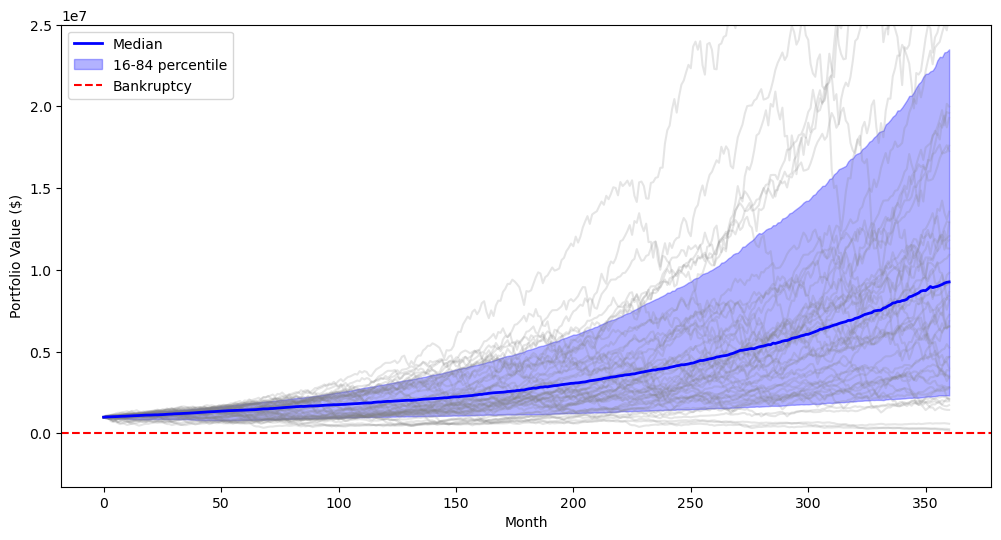

In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# -----------------------------
# 1) Fetch monthly close prices
# -----------------------------
ticker = "SPY"
df = yf.download(ticker, start="2000-01-01", progress=False)['Close']
prices = df.resample('ME').last()  # monthly end prices
hist_rets = prices.pct_change().dropna().values  # 1D array

# -----------------------------
# 2) Simulation parameters
# -----------------------------
years = 30
months = years * 12
start_capital = 1_000_000
withdrawal_rate = 0.04
monthly_withdrawal = start_capital * withdrawal_rate / 12
inflation_rate = 0.025
monthly_inflation = (1 + inflation_rate)**(1/12) - 1
n_sim = 5000
avg_block_size = 60  # months

# -----------------------------
# 3) Stationary block bootstrap function
# -----------------------------
def bootstrap_path(data, length, avg_block):
    data = np.asarray(data).flatten()
    path = []
    while len(path) < length:
        start = np.random.randint(0, len(data))
        block_len = np.random.geometric(1/avg_block)
        block_len = min(block_len, len(data)-start, length-len(path))
        path.extend(data[start:start+block_len])
    return np.array(path)

# -----------------------------
# 4) Run bootstrap simulations
# -----------------------------
paths = np.zeros((n_sim, months+1))
paths[:,0] = start_capital

for s in range(n_sim):
    synthetic = bootstrap_path(hist_rets, months, avg_block_size)
    capital = start_capital
    withdrawal = monthly_withdrawal
    for t in range(months):
        capital *= (1 + synthetic[t])
        capital -= withdrawal
        withdrawal *= (1 + monthly_inflation)
        paths[s, t+1] = max(capital, 0)  # can't go below 0
        if capital <= 0:
            paths[s, t+1:] = 0
            break

# -----------------------------
# 5) Statistics
# -----------------------------
final_vals = paths[:,-1]
print("Median final wealth: $", f"{np.median(final_vals):,.0f}")
print("16th percentile: $", f"{np.percentile(final_vals,16):,.0f}")
print("84th percentile: $", f"{np.percentile(final_vals,84):,.0f}")

# -----------------------------
# 6) Quick visualization
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(paths[np.random.choice(n_sim, 50, replace=False)].T, color='grey', alpha=0.2)
plt.plot(np.median(paths, axis=0), color='blue', linewidth=2, label='Median')
plt.fill_between(np.arange(months+1), 
                 np.percentile(paths,16,axis=0), 
                 np.percentile(paths,84,axis=0),
                 color='blue', alpha=0.3, label='16-84 percentile')
plt.axhline(0, color='red', linestyle='--', label='Bankruptcy')
plt.xlabel("Month")
plt.ylabel("Portfolio Value ($)")
plt.ylim(None, 25e6)
plt.legend()
plt.show()


## 🔹 Understanding Monte Carlo Retirement Simulations with Block Bootstrap

In this simulation, we model the evolution of a retirement portfolio over **30 years** using historical S&P 500 returns. Instead of simply averaging past returns, we generate **synthetic future scenarios** by resampling **contiguous multi-year blocks** of historical returns. This preserves the natural patterns of bull and bear markets, which is crucial for realistic long-term compounding.  

### How It Works

1. **Historical Data as Source:** We use real monthly returns of the S&P 500 as the basis.  
2. **Block Bootstrap Sampling:** Instead of drawing individual months randomly (which destroys temporal correlations), we sample **5-year blocks** (60 months) to retain market trends.  
3. **Portfolio Simulation:** For each bootstrap path, we simulate withdrawals, inflation adjustments, and compounding over 30 years. This produces thousands of hypothetical retirement trajectories.  
4. **Outcome Distribution:** By repeating the simulation many times (Monte Carlo), we build a distribution of possible outcomes rather than a single deterministic forecast.

### Why It’s Useful

- It **accounts for sequence-of-returns risk**: early losses can drastically impact long-term wealth if withdrawals occur during down markets.  
- It gives a **probabilistic view**: instead of guessing a single future, we see a range of outcomes and the likelihood of success.  
- It helps investors and students understand that **historical returns are not guaranteed**, but their patterns contain valuable information about market dynamics.

### Interpreting the Results

Using a realistic setup (initial portfolio \$1,000,000, 4% annual withdrawal, inflation 2.5%, 30-year horizon, 5-year blocks):

- **Median final wealth:** \$9,267,268  
- **16th percentile:** \$2,322,963  
- **84th percentile:** \$23,494,365  

**Key Takeaways:**

- The **median** shows the "typical" outcome — if history repeats roughly in blocks, a million-dollar portfolio grows to ~\$9M over 30 years.  
- The **16th percentile** highlights downside risk — in 1 out of 6 scenarios, the portfolio might shrink to ~\$2.3M.  
- The **84th percentile** represents upside potential — in 1 out of 6 scenarios, the portfolio could exceed ~\$23M.  

This **classic result** illustrates the power of compounding, the importance of sequence-of-returns, and why Monte Carlo simulations are indispensable for retirement planning.
